# Analysis of results from experimental campaign

This notebook explores and visualize the results on `MicroGridEnv` adopting different strategies. The results are retrieved from some `json`files employed to store the outcome from the testing of each tested algorithm. <br>
The plots shown here have been also used within the paper.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/Users/dave/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Repositories/ernesto-gym


In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm 
from datetime import datetime
import os
import orjson as json
from pathlib import Path
from collections import OrderedDict

from ernestogym.envs import MicroGridEnv
from ernestogym.envs.single_agent.utils import parameter_generator

sns.set_style('darkgrid')
plot_colors = sns.color_palette()
sns.set(font_scale=1.4)

params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          #"axes.edgecolor" : "black",
          "text.usetex" : True,
          "text.latex.preamble": r'\usepackage{amsmath} \usepackage{amssymb}',
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"],          
          "font.size": 18
}
plt.rcParams.update(params)

plots_dir = 'examples/single_agent/plots/ijcnn25'
os.makedirs(plots_dir, exist_ok=True)

In [66]:
alg_color = OrderedDict({
    'random': plot_colors[0],
    'only_market': plot_colors[1],
    'battery_first': plot_colors[2],
    '20-80': plot_colors[3],
    '50-50': plot_colors[4],
    '80-20': plot_colors[5],
    'ppo': plot_colors[0],
    'a2c': plot_colors[6],
    'sac': plot_colors[7],
    'ppo_fixed_market_tamb': plot_colors[6],
    'ppo_fixed_tamb': plot_colors[7],
    'ppo_25eps': plot_colors[8],
    'ppo-no_retrain': plot_colors[9],
    'ppo_4-100': plot_colors[7]
})

alg_markers = OrderedDict({
    'random': '.',
    'only_market': 'o',
    'battery_first': 'v',
    '20-80': 's',
    '50-50': 'P',
    '80-20': 'D',
    'ppo': '*',
    'a2c': '+',
    'sac': '<',
    'ppo_fixed_market_tamb': '+',
    'ppo_fixed_tamb': '>',
    'ppo_25eps': '',
    'ppo-no_retrain': '',
    'ppo_4-100': ''
})

In [67]:
file_names = {
    "REPLACEMENT_COST_200": 200,
    "REPLACEMENT_COST_1000": 1000,
    "BEST-IJCNN_2015-2020_deg_new-norm_clip0_1_socmax_gamma0_99_new-market": 3000,
    "REPLACEMENT_COST_5000": 5000,
    "REPLACEMENT_COST_10000": 10000,
}

In [68]:
folder = "./logs/"

In [103]:
algs = ['battery_first', 'only_market', 'ppo_fixed_market_tamb', 'ppo',]# 'ppo_fixed_tamb']

In [70]:
exp_folders = list(file_names.keys())

In [71]:
def load_results():
    res = {}
    
    for exp_file in tqdm(exp_folders):
        res[file_names[exp_file]] = {}
        
        for alg in algs:
            alg_res = []
            results_folder = folder + exp_file + '/results/' + alg + '/'
            tests_files = [f for f in os.listdir(results_folder)]

            for file in tests_files:
                f = open (results_folder + file, "r")
                data = json.loads(f.read())
                alg_res.append(data)
            
            res[file_names[exp_file]][alg] = alg_res
    return res

In [72]:
res_dict = load_results()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.13s/it]


In [73]:
res_dict.keys()

dict_keys([200, 1000, 3000, 5000, 10000])

In [74]:
alg_names = {
    'a2c': 'A2C',
    'battery_first': 'BF',
    '20-80': '20-80',
    'random': 'Random',
    'ppo': r'RL$^{\star}$',
    '50-50': '50-50',
    '80-20': '80-20',
    'only_market': 'OG',
    'sac': 'SAC',
    'ppo_fixed_market_tamb': 'RL-base',
    'ppo_fixed_tamb': 'RL-base+',
    'ppo_25eps': 'PPO_25EPS',
    'ppo-no_retrain': 'PPO_NO-RETRAIN',
    'ppo_4-100': 'PPO_4envs-100eps'
}

In [75]:
def savefig(fig: plt.Figure, filename: str, **kwargs) -> None:
    if not do_not_save:
        save_path = os.path.join(plots_dir, filename)
        fig.savefig(save_path, dpi=300, bbox_inches='tight', **kwargs)

In [100]:
do_not_save = False

## PLOTS

In [87]:
def compute_means():
    means_dict = {}
    
    for key, values in res_dict.items():
        means_dict[key] = {}
        profiles = list(range(len(values['only_market'])))
        
        for i, alg in enumerate(algs):
            returns = [np.sum(values[alg][i]['pure_reward']['r_trad']) + np.sum(values[alg][i]['pure_reward']['r_deg']) for i in profiles]
            means_dict[key][alg] = np.mean(returns)
            
    return means_dict   

In [88]:
def compute_cis():
    ci_dict = {}
    
    for key, values in res_dict.items():
        ci_dict[key] = {}
        profiles = list(range(len(values['only_market'])))
        
        for i, alg in enumerate(algs):
            returns = [np.sum(values[alg][i]['pure_reward']['r_trad']) + np.sum(values[alg][i]['pure_reward']['r_deg']) for i in profiles]
            ci_dict[key][alg] = 1.96 * np.std(returns) / np.sqrt(len(profiles))
            
    return ci_dict   

In [89]:
def compute_returns(): 
    returns_dict = {}
    
    for key, values in res_dict.items():
        returns_dict[key] = {}
        profiles = list(range(len(values['only_market'])))
        
        for i, alg in enumerate(algs):
            returns = [np.sum(values[alg][i]['pure_reward']['r_trad']) + np.sum(values[alg][i]['pure_reward']['r_deg']) for i in profiles]
            returns_dict[key][alg] = returns
    
    return returns_dict   

In [90]:
means_dict = compute_means()

In [91]:
means_dict = dict(sorted(means_dict.items()))

In [92]:
means_dict

{200: {'battery_first': -12.73946909694457,
  'only_market': -131.20148474153808,
  'ppo': -58.95763013171387,
  'ppo_fixed_market_tamb': -130.00524404243177},
 1000: {'battery_first': -110.98124199359692,
  'only_market': -189.1803458326941,
  'ppo': -125.28384696561626,
  'ppo_fixed_market_tamb': -175.91842818792674},
 3000: {'battery_first': -356.5856742352278,
  'only_market': -334.1274985605842,
  'ppo': -312.65244361716753,
  'ppo_fixed_market_tamb': -322.6810201933131},
 5000: {'battery_first': -602.1901064768588,
  'only_market': -479.0746512884742,
  'ppo': -479.3197131599976,
  'ppo_fixed_market_tamb': -670.2141268125079},
 10000: {'battery_first': -1216.201187080936,
  'only_market': -841.4425331081994,
  'ppo': -851.6578213606788,
  'ppo_fixed_market_tamb': -841.4425331081994}}

In [93]:
ci_dict = compute_cis()

In [94]:
ci_dict = dict(sorted(ci_dict.items()))

In [95]:
ci_dict

{200: {'battery_first': 32.04042375562921,
  'only_market': 42.680229689006836,
  'ppo': 41.27526797386678,
  'ppo_fixed_market_tamb': 42.729802920603404},
 1000: {'battery_first': 30.181020636308165,
  'only_market': 42.68022968900684,
  'ppo': 37.196409663638306,
  'ppo_fixed_market_tamb': 42.79379191849692},
 3000: {'battery_first': 25.602973089094668,
  'only_market': 42.68022968900684,
  'ppo': 34.54882976292551,
  'ppo_fixed_market_tamb': 39.225105965785346},
 5000: {'battery_first': 21.17769758752303,
  'only_market': 42.680229689006836,
  'ppo': 41.92108686791546,
  'ppo_fixed_market_tamb': 25.86857590802815},
 10000: {'battery_first': 11.939255496486547,
  'only_market': 42.68022968900685,
  'ppo': 41.77054977518842,
  'ppo_fixed_market_tamb': 42.68022968900685}}

In [96]:
returns_dict = compute_returns()

In [97]:
returns_dict = dict(sorted(returns_dict.items()))

In [104]:
def plot_dichotomy_analysis():
    fig, ax = plt.subplots(figsize=(10, 4), tight_layout=True)
    patches = []
    
    for alg in algs:
        patches.append(Patch(facecolor=alg_color[alg], alpha=0.8, edgecolor=alg_color[alg], label=alg_names[alg]))
        
        y = np.array([means_dict[key][alg] for key in means_dict.keys()])
        ci = np.array([ci_dict[key][alg] for key in ci_dict.keys()])
        
        #ax.errorbar(x=list(means_dict.keys()), y=y, yerr=ci, color=alg_color[alg], ls='-', lw=1.5, marker='.', capsize=5, capthick=1)
        ax.plot(list(means_dict.keys()), y, color=alg_color[alg], ls='-', lw=1.5, marker=alg_markers[alg])
        #ax.fill_between(list(ci_dict.keys()), y+ci, y-ci, color=alg_color[alg], alpha=0.1)
    ax.set(ylabel=r'$\widehat{R}_\mathcal{T}\,(\mathfrak{U})$', 
           xlabel=r'$\mathcal{R}$',
           xticks=list(means_dict.keys())) 
    ax.legend(handles=patches, ncols=[2,2])

    savefig(fig, filename='replacement_cost_analysis.pdf')
    savefig(fig, filename='replacement_cost_analysis.png')

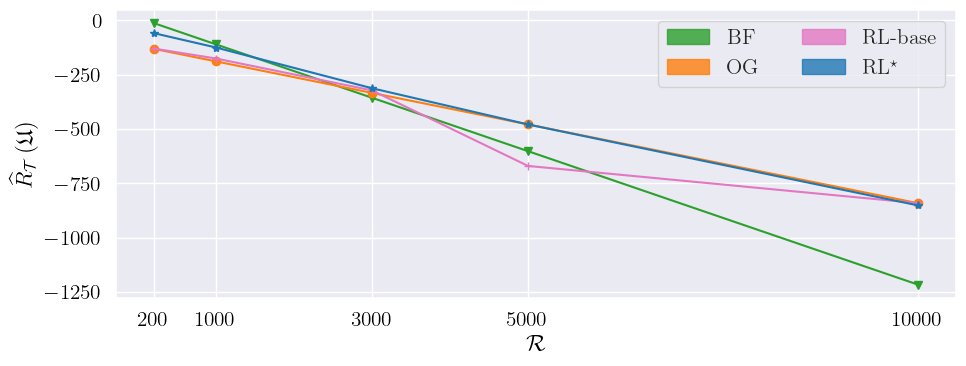

In [105]:
plot_dichotomy_analysis()